<a href="https://colab.research.google.com/github/EngUzair98/CS867_Computer_Vision_Projects/blob/main/CS867_CV_A001_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Libraries

In [211]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import classification_report, confusion_matrix
from scipy import ndimage
from scipy.spatial import distance
from sklearn.cluster import KMeans
from scipy.cluster.vq import vq
from sklearn import svm
from sklearn.preprocessing import StandardScaler
import seaborn as sns

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#Importing & Loading Dataset

In [212]:
dataset_BST= '/content/gdrive/MyDrive/BelgiumSTC'

In [213]:
os.listdir(dataset_BST)

['Test', 'Train']

In [214]:
label_sign= {'00001':0, '00002':1, '00003':2, '00004':3, '00005':4, '00006':5, '00007':6, '00008':7, '00009':8, '00010':9}

In [215]:
#loading data into memory disk
def load_Data():
  sub_dir= ["Train","Test"]
  output=[]
  for subDirec in sub_dir:
    parent_path= os.path.join(dataset_BST, subDirec)
    print(parent_path)
    imgs=[]
    labels=[]

    for lbl_folder in os.listdir(parent_path):
      target_lbls= label_sign[lbl_folder]
      child_path= os.path.join(parent_path, lbl_folder) #assigning labeled folders to Train and Test folders

      #Iterating through each image in child path
      for lbl_file in os.listdir(child_path):
         #assigning images to related child path folders
        img_path=os.path.join(child_path, lbl_file)
        img= cv2.imread(img_path)

        #Append imgs and labels to output images and labels
        if img is not None: 
          imgs.append(img)
          labels.append(target_lbls)

    output.append((imgs,labels))

  return output

In [216]:
(img_train, lbl_train), (img_test, lbl_test) = load_Data()

/content/gdrive/MyDrive/BelgiumSTC/Train
/content/gdrive/MyDrive/BelgiumSTC/Test


In [217]:
# len(img_train)

In [218]:
# len(img_test)

In [219]:
# len(lbl_train)

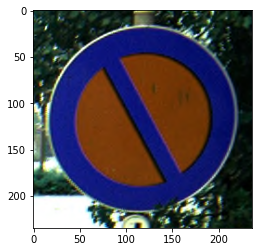

In [220]:
plt.imshow(img_train[90])
plt.show()

#Implementing Feature Extractor Sift

In [221]:
def SIFT(image):
  #Defining SIFT Feature Extractor to extract keypoints and descriptors
  sift_FE= cv2.xfeatures2d.SIFT_create()

  #initilizing lists to store all possible keypoints and descriptors
  keyP = []
  desCrip = []
  
  #extracting all possible keypoints and descriptors for training & test image dataset
  for img in image:
    img_kp, img_desCrip = sift_FE.detectAndCompute(img,None)
    keyP.append(img_kp)
    desCrip.append((img,img_desCrip))
  
  return(keyP, desCrip)

In [222]:
kpD_train = SIFT(img_train)
kpD_test = SIFT(img_test)

Visulizing Train & Test images

In [223]:
#Visualizing few images with extracted features
def sift_visulise(image, keyPoint):
  op_img = []
  for i in range(5):
    img_sift = cv2.drawKeypoints(image[i], keyPoint[i], 0, (255,0,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    op_img.append(img_sift)
    plt.imshow(op_img[i])
    op_plot=plt.show()
  
  return op_plot

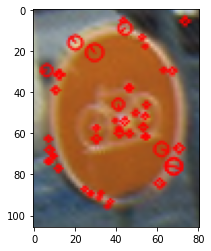

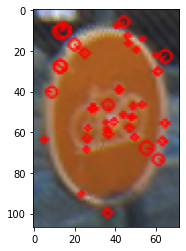

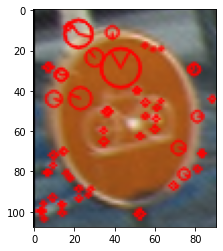

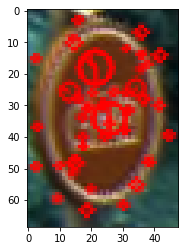

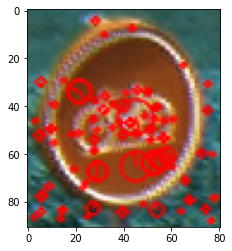

In [224]:
kp_train = kpD_train[0]
train_visulize = sift_visulise(img_train, kp_train)

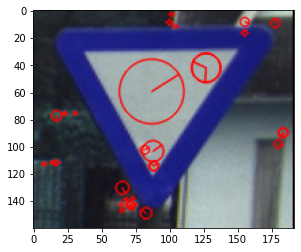

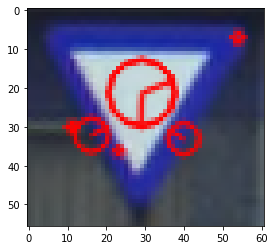

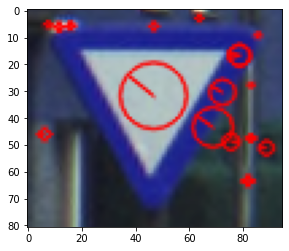

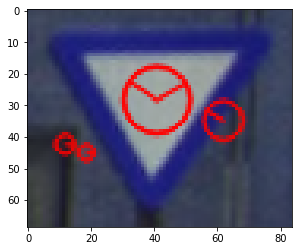

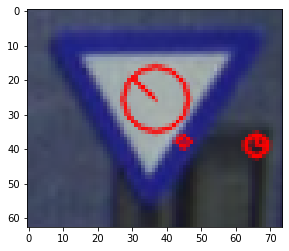

In [225]:
kp_test = kpD_test[0]
test_visulize = sift_visulise(img_test, kp_test)

Stacking all the generated training descriptors in to a single numpy array & converting it to float type

In [226]:
def all_desCrip(des):
  desCriP=des[0][1]
  for image_path,descriptor in des[1:]:
      desCriP=np.vstack((desCriP,descriptor))
  
  return desCriP

In [227]:
des_train=kpD_train[1]
all_tr_des = all_desCrip(des_train)

In [228]:
all_tr_des.shape

(67326, 128)

In [229]:
desCrip_float=all_tr_des.astype(float)

#Clustering & Bag of Visual Words genaration

In [230]:
#Implementing kmeans clustering to achive bag of visual words
def kmeans(k, desCrip_list):
    kmeans = KMeans(n_clusters = k, n_init=10)
    kmeans.fit(desCrip_list)
    bagOf_VW = kmeans.cluster_centers_ 
    return bagOf_VW
     
BofVW = kmeans(400, desCrip_float) 

(array([[217., 109.,  46., ...,   0.,   0.,   0.],
        [280.,  71.,  25., ...,   0.,   0.,   0.],
        [303.,  52.,  23., ...,   1.,   0.,   0.],
        ...,
        [310.,  57.,  18., ...,   0.,   0.,   0.],
        [341.,  32.,  12., ...,   0.,   0.,   0.],
        [327.,  51.,  10., ...,   0.,   0.,   0.]]),
 array([-2.84217094e-14,  1.90459459e+01,  3.80918919e+01,  5.71378378e+01,
         7.61837838e+01,  9.52297297e+01,  1.14275676e+02,  1.33321622e+02,
         1.52367568e+02,  1.71413514e+02,  1.90459459e+02]),
 <a list of 128 Lists of Patches objects>)

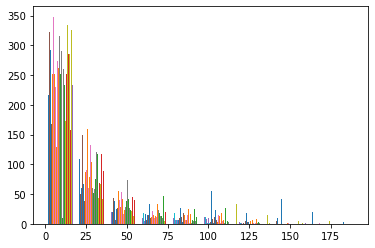

In [231]:
#Plotting Bag of Visual Words
plt.hist(BofVW)

Generating new training and test features based on extracted descriptors and bag of visual words

In [248]:
#Generating training & testing features
def features(images, desCrip, visualWords):
  k=400
  new_features=np.zeros((len(images),k),"float32")
  for i in range(len(images)):
      words,distance=vq(desCrip[i][1],visualWords)
      for w in words:
          new_features[i][w]+=1
  
  return new_features

In [249]:
train_features = features(img_train, des_train, BofVW)

In [250]:
des_test = kpD_test[1]
test_features = features(img_test, des_test, BofVW)

In [251]:
len(BofVW), len(train_features), len(test_features)

(400, 800, 200)

In [253]:
# train_features

(array([[794.,   5.,   1., ...,   0.,   0.,   0.],
        [799.,   1.,   0., ...,   0.,   0.,   0.],
        [800.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [726.,  46.,  14., ...,   0.,   0.,   0.],
        [797.,   3.,   0., ...,   0.,   0.,   0.],
        [800.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([ 0. ,  4.6,  9.2, 13.8, 18.4, 23. , 27.6, 32.2, 36.8, 41.4, 46. ],
       dtype=float32),
 <a list of 400 Lists of Patches objects>)

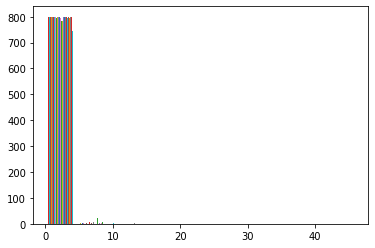

In [254]:
#Plotting new training Features
plt.hist(train_features)

In [255]:
# test_features

(array([[197.,   2.,   1., ...,   0.,   0.,   0.],
        [200.,   0.,   0., ...,   0.,   0.,   0.],
        [197.,   3.,   0., ...,   0.,   0.,   0.],
        ...,
        [169.,  14.,   5., ...,   0.,   0.,   0.],
        [200.,   0.,   0., ...,   0.,   0.,   0.],
        [200.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([ 0. ,  2.3,  4.6,  6.9,  9.2, 11.5, 13.8, 16.1, 18.4, 20.7, 23. ],
       dtype=float32),
 <a list of 400 Lists of Patches objects>)

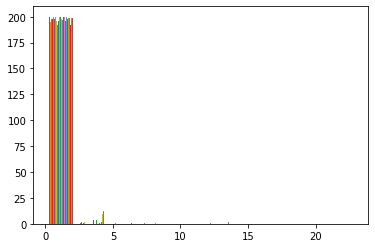

In [256]:
#Plotting new test Features
plt.hist(test_features)

#Training and Evaluation SVM Classifier

In [257]:
# Training SVM on new training fetures
# stdScaler=StandardScaler().fit(train_features)
# train_features=stdScaler.transform(train_features)
svm_classifier=svm.SVC()
svm_classifier.fit(train_features,lbl_train)

SVC()

In [258]:
# test_features=stdScaler.transform(test_features)

#Evaluation Results

In [259]:
# Generating Classification Report on evalution results
lblTrue=lbl_test
lblPred= svm_classifier.predict(test_features)
print("SVM Model Classification Report: \n",classification_report(lblTrue,lblPred, target_names=label_sign))

SVM Model Classification Report: 
               precision    recall  f1-score   support

       00001       0.76      0.80      0.78        20
       00002       1.00      0.85      0.92        20
       00003       0.89      0.80      0.84        20
       00004       1.00      0.95      0.97        20
       00005       0.60      0.60      0.60        20
       00006       0.83      0.75      0.79        20
       00007       0.43      0.65      0.52        20
       00008       0.81      0.85      0.83        20
       00009       0.95      0.95      0.95        20
       00010       0.62      0.50      0.56        20

    accuracy                           0.77       200
   macro avg       0.79      0.77      0.78       200
weighted avg       0.79      0.77      0.78       200



Text(91.68, 0.5, 'Actual')

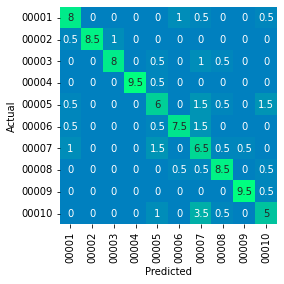

In [260]:
cm=confusion_matrix(lblTrue, lblPred) 
cm_percent=(cm/np.sum(cm))*100
sns.heatmap(cm_percent, cmap='winter', center=0, square=True, annot=True, xticklabels=label_sign, yticklabels=label_sign, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')

#Visualizing Misclassified Images

In [261]:
misClass_img= test_features[lblPred!=lblTrue]
corrClass_img= test_features[lblPred==lblTrue]

print("No. of Misclassified Images: ", misClass_img.shape[0])
print("No. of Correctly classified Images: ", corrClass_img.shape[0])

No. of Misclassified Images:  46
No. of Correctly classified Images:  154


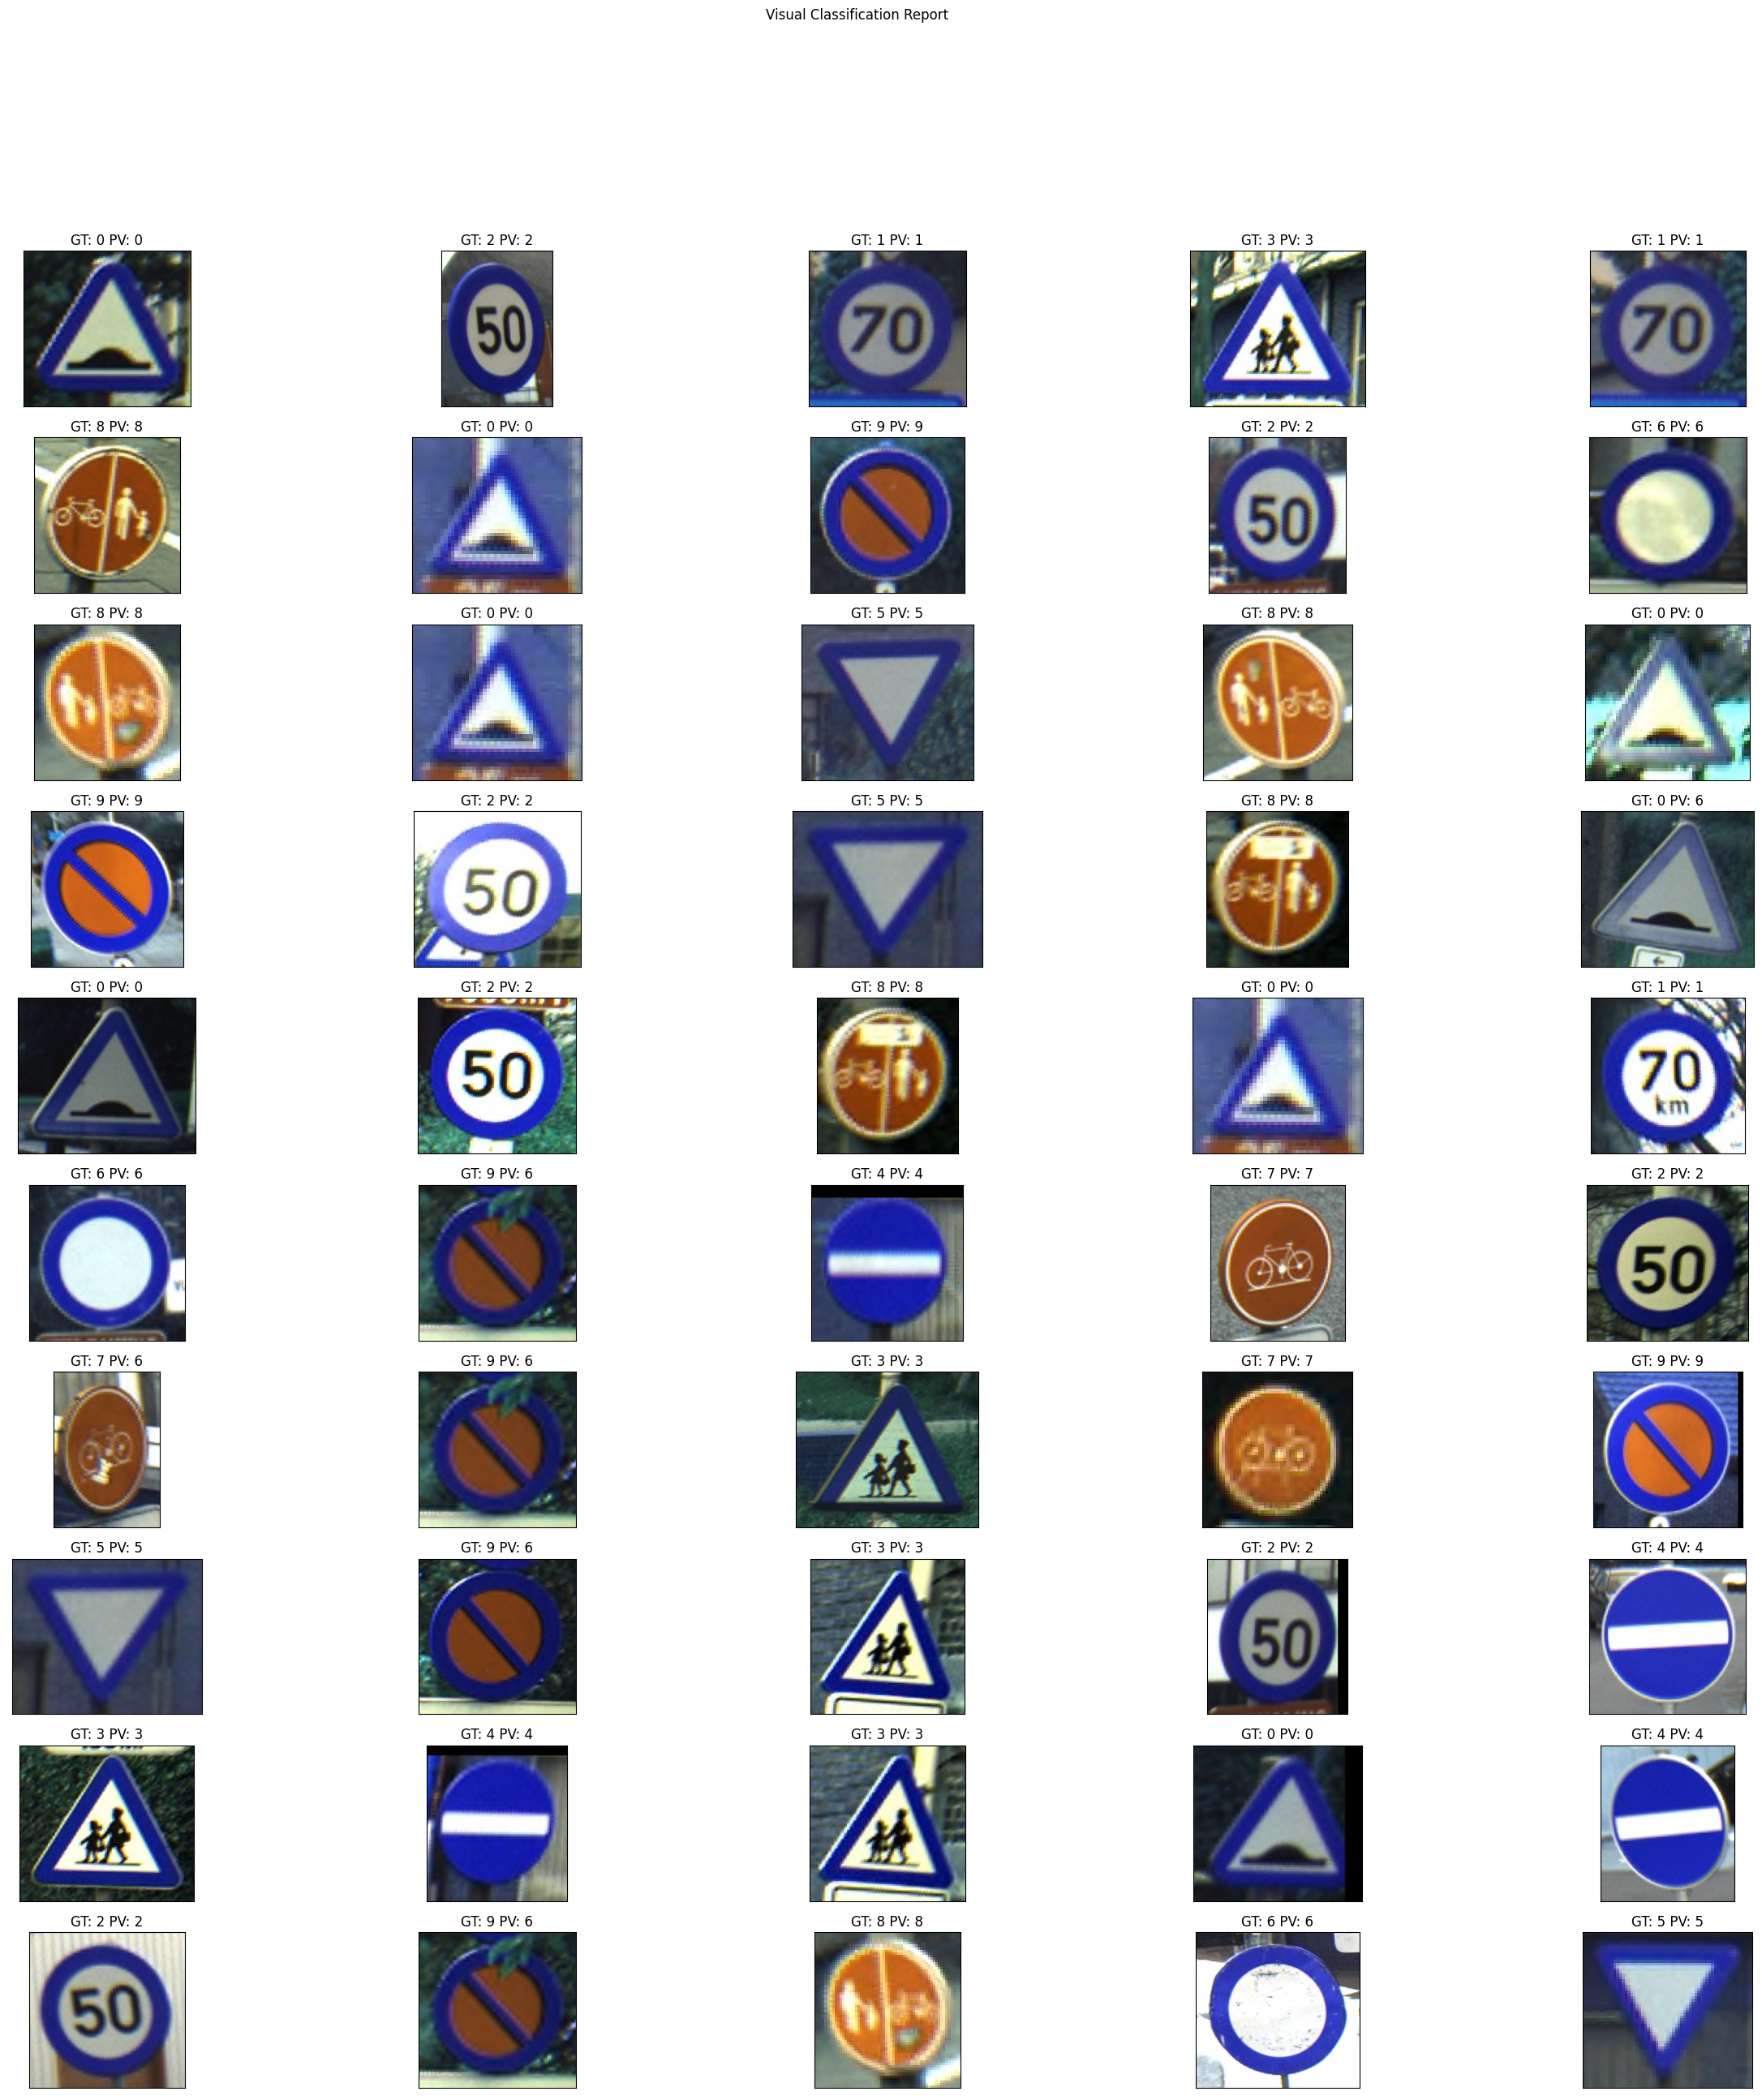

In [262]:
imgSize=(30,30) #resizing images for collective view
dim_img=plt.figure(figsize=imgSize, dpi=100)
dim_img.suptitle("Visual Classification Report", fontsize=12)
for i in range(50):
    plt.subplot(10, 5, i+1) #Displaying 50 imgs in 10 rows and 5 columns
    index=np.random.randint(len(img_test))
    plt.imshow(img_test[index])
    plt.title('GT: {} PV: {}'.format(lblTrue[index],lblPred[index]), fontsize=12) # GT=Ground Truth & PV = Predicted Value

    plt.xticks([])
    plt.yticks([])

plt.show()